<a href="https://colab.research.google.com/github/sokrypton/af2bind/blob/main/af2bind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AF2BIND: Prediction of ligand-binding sites using AlphaFold2

AF2BIND is a simple and fast notebook that runs inference on the output obtained from [Alphafold](https://github.com/deepmind/alphafold).


The method utilizes [ColabDesign](https://github.com/sokrypton/ColabDesign) binder protocol framework which facilitates the identification of binding sites for protein-ligand complexes.

Notebook Authors/Collaborators :

*   Artem Gazizov (artemg97@mit.edu)
*    Sergey Ovchinnikov (so@fas.harvard.edu)
*    Nicholas Polizzi (nicholasf_polizzi@dfci.harvard.edu)

<!--<img src="https://raw.githubusercontent.com/artemg97/af2bind_prod/main/logo.png" width="300">.-->

<figure>
<center>
<img src='https://raw.githubusercontent.com/artemg97/af2bind_prod/main/logo.png'  width="300" height="150"  align=left />
</figure>





In [ ]:
%%time
#@title Install AlphaFold2 (~2 mins)
#@markdown Please execute this cell by pressing the *Play* button on
#@markdown the left.
#@markdown
#@markdown **Note**: This installs the Colabdesign framework
import os, time
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar; \
  mkdir af2bind_params; \
  wget -qnc https://github.com/sokrypton/af2bind/raw/main/attempt_7_2k_lam0-03.zip; unzip attempt_7_2k_lam0-03.zip -d af2bind_params; \
  wget -qnc https://github.com/sokrypton/af2bind/raw/main/attempt_8_2k_lam0-03.zip; unzip attempt_8_2k_lam0-03.zip -d af2bind_params; \
  tar -xf alphafold_params_2021-07-14.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)

import os
from colabdesign import mk_afdesign_model
from IPython.display import HTML
from google.colab import files
import numpy as np

from colabdesign.af.alphafold.common import residue_constants
import pandas as pd
from google.colab import data_table
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.3f}"
from IPython.display import display, HTML
import jax, pickle
import jax.numpy as jnp
from scipy.special import expit as sigmoid
import plotly.express as px

aa_order = {v:k for k,v in residue_constants.restype_order.items()}

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb")
    return f"AF-{pdb_code}-F1-model_v4.pdb"

def af2bind(outputs, mask_sidechains=True, add_bias_before=False, seed=0):
  pair_A = outputs["representations"]["pair"][:-20,-20:]
  pair_B = outputs["representations"]["pair"][-20:,:-20].swapaxes(0,1)
  pair_A = pair_A.reshape(pair_A.shape[0],-1)
  pair_B = pair_B.reshape(pair_B.shape[0],-1)
  x = np.concatenate([pair_A,pair_B],-1)

  # get params
  if mask_sidechains:
    model_type = f"split_nosc_pair_A_split_nosc_pair_B_{seed}"
  else:
    model_type = f"split_pair_A_split_pair_B_{seed}"
  if add_bias_before:
   with open(f"af2bind_params/attempt_8_2k_lam0-03/{model_type}.pickle","rb") as handle:
    params_ = pickle.load(handle)["~"]
  else:
    with open(f"af2bind_params/attempt_7_2k_lam0-03/{model_type}.pickle","rb") as handle:
      params_ = pickle.load(handle)
    params_ = dict(**params_["~"], **params_["linear"])
  p = jax.tree_map(lambda x:np.asarray(x), params_)

  # get predictions
  x = (x - p["mean"]) / p["std"]
  if add_bias_before:
    x = (x + p["b"]) * p["w"][:,0]
  else:
    x = (x * p["w"][:,0]) + (p["b"] / x.shape[-1])
  p_bind_aa = x.reshape(x.shape[0],2,20,-1).sum((1,3))
  p_bind = sigmoid(p_bind_aa.sum(-1))
  return {"p_bind":p_bind, "p_bind_aa":p_bind_aa}

installing ColabDesign
downloading params
CPU times: user 2.11 s, sys: 342 ms, total: 2.45 s
Wall time: 54 s


In [ ]:
#@title **Run AF2BIND** 🔬
target_pdb = "6w70" #@param {type:"string"}
target_chain = "A" #@param {type:"string"}
#@markdown - Please indicate target pdb and chain (leave pdb blank for custom upload)
mask_sidechains = True # @param {type:"boolean"}
mask_sequence = False
pdb_filename = get_pdb(target_pdb)

if "af_model" not in dir():
  af_model = mk_afdesign_model(protocol="binder", debug=True)

af_model.prep_inputs(pdb_filename=pdb_filename,
                     chain=target_chain,
                     binder_len=20,
                     rm_target_sc=mask_sidechains,
                     rm_target_seq=mask_sequence)

# split
r_idx = af_model._inputs["residue_index"][-20] + (1 + np.arange(20)) * 50
af_model._inputs["residue_index"][-20:] = r_idx.flatten()

af_model.set_seq("ACDEFGHIKLMNPQRSTVWY")
af_model.predict(verbose=False)

o = af2bind(af_model.aux["debug"]["outputs"],
            mask_sidechains=mask_sidechains)
pred_bind = o["p_bind"].copy()
pred_bind_aa = o["p_bind_aa"].copy()

#######################################################
labels = ["chain","resi","resn","p(bind)"]
data = []
for i in range(af_model._target_len):
  c = af_model._pdb["idx"]["chain"][i]
  r = af_model._pdb["idx"]["residue"][i]
  a = aa_order.get(af_model._pdb["batch"]["aatype"][i],"X")
  p = pred_bind[i]
  data.append([c,r,a,p])

df = pd.DataFrame(data, columns=labels)
df.to_csv('results.csv')

data_table.enable_dataframe_formatter()
df_sorted = df.sort_values("p(bind)",ascending=False, ignore_index=True).rename_axis('rank').reset_index()
display(data_table.DataTable(df_sorted, min_width=100, num_rows_per_page=15, include_index=False))

top_n = 15
top_n_idx = pred_bind.argsort()[::-1][:15]
pymol_cmd="select ch"+str(target_chain)+","
for n,i in enumerate(top_n_idx):
  p = pred_bind[i]
  c = af_model._pdb["idx"]["chain"][i]
  r = af_model._pdb["idx"]["residue"][i]
  pymol_cmd += f" resi {r}"
  if n < top_n-1:
    pymol_cmd += " +"

print("\n🧪Pymol Selection Cmd:")
print(pymol_cmd)

,rank,chain,resi,resn,p(bind)
0,0,A,79,F,0.980824
1,1,A,112,T,0.980098
2,2,A,16,A,0.974073
3,3,A,13,G,0.969093
4,4,A,46,Y,0.963965
...,...,...,...,...,...
121,121,A,8,E,0.004462
122,122,A,125,A,0.003445
123,123,A,64,G,0.003438
124,124,A,1,S,0.003259



🧪Pymol Selection Cmd:
select chA, resi 79 + resi 112 + resi 16 + resi 13 + resi 46 + resi 17 + resi 108 + resi 119 + resi 49 + resi 75 + resi 82 + resi 115 + resi 20 + resi 111 + resi 116


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

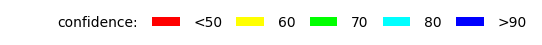

In [ ]:
import matplotlib.pyplot as plt
from scipy.special import softmax
import copy

#@title **Display Structure (Colored by Confidence)**
#partly inspired by OpeFold - https://colab.research.google.com/github/aqlaboratory/openfold/blob/main/notebooks/OpenFold.ipynb#scrollTo=rowN0bVYLe9n
#color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
rescale_by_max_pbind = False #@param {type:"boolean"}
use_native_coordinates = False #@param {type:"boolean"}
show_ligand = False

if rescale_by_max_pbind:
  preds_adj = pred_bind.copy() / pred_bind.max()
else:
  preds_adj = pred_bind.copy()

# replace plddt and coordinates of prediction
L = af_model._target_len
aux = copy.deepcopy(af_model.aux["all"])
aux["plddt"][:,:L] = preds_adj
if show_ligand:
  af_model.save_pdb("output.pdb",aux={"all":aux})
else:
  if use_native_coordinates:
    native_coords = af_model._pdb["batch"]["all_atom_positions"][:L].copy()
    aux["atom_positions"][:,:L] = native_coords
  aux["atom_mask"][:,L:] = 0
  af_model.save_pdb("output.pdb",aux={"all":aux})

af_model.plot_pdb(aux={"all":aux})

def plot_plddt_legend(dpi=100):
  thresh = ['confidence:','<50','60','70','80','>90']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt
plot_plddt_legend().show()

In [ ]:
#@title **Download Predictions**
from google.colab import files
os.system(f"zip -r output.zip output.pdb results.csv")
files.download(f'output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title **Activation analysis**
pbind_cutoff = 0.5 # @param ["0.0", "0.5", "0.9"] {type:"raw"}
add_bias_before = False

o = af2bind(af_model.aux["debug"]["outputs"],
            mask_sidechains=mask_sidechains,
            add_bias_before=add_bias_before)
pred_bind = o["p_bind"].copy()
pred_bind_aa = o["p_bind_aa"].copy()

blosum_map = list("CSTAGPDEQNHRKMILVWYF")
cs_label_list = list("ACDEFGHIKLMNPQRSTVWY")

indices_A_Y_mapping = np.array([cs_label_list.index(letter) for letter in blosum_map])
pred_bind_aa_blosum = pred_bind_aa[:,indices_A_Y_mapping]
filt = pred_bind > pbind_cutoff
pred_bind_aa_blosum = pred_bind_aa_blosum[filt]
res_labels = np.array(af_model._pdb["idx"]["residue"])[filt]


fig = px.imshow(pred_bind_aa_blosum.T,
                labels=dict(x="positions", y="amino acids", color="pref"),
                y=blosum_map,
                x=[str(x) for x in res_labels] if pbind_cutoff > 0 else res_labels,
                zmin=-1,
                zmax=1,
                template="simple_white",
                color_continuous_scale=["red", "white", "blue"],
              )
fig.show()